# FineST in HCC Visium data

## Main steps

- Step1: Align image patch and ST spot: using image pixels with spot coordinates
- Step2: Train model on within-spots: train model on 80% - test on 20% of the data
- Step3: Infer gene expression of between-spots using the trained model
- Step4: Impute (smooth) on all sub-spots using measured spot expression

In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.INFO)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
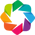

FineST version: 0.1.2
CUDA is available. GPU: NVIDIA A100-PCIE-40GB


In [2]:
## From local
path = '/mnt/lingyu/nfs_share2/Python/'
os.chdir(str(path) + 'FineST/FineST/')
import FineST as fst
from FineST.utils import device
from FineST.datasets import dataset
import FineST.plottings as fstplt
print("FineST version: %s" %fst.__version__)

## install FineST package
# import FineST as fst
# from FineST.datasets import dataset
# import FineST.plottings as fstplt
# print("torch version: %s" %torch.__version__)
# print("FineST version: %s" %fst.__version__)

fst.setup_seed(666)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
## Set path
path = '/mnt/lingyu/nfs_share2/Python/'
# os.chdir(f'{path}FineST/FineST/')
os.chdir(f'{path}FineST/FineST_demo/')    # here I use FineST_demo

## Set logging
model_folder = 'logging/'
dir_name = model_folder + datetime.now().strftime('%Y%m%d%H%M%S%f')
print('dir_name: ', dir_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    logger = fst.setup_logger(dir_name)

## Set parameter 
parameter_file_path = 'parameter/parameters_HCC_virchow2_modify.json'
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)
logger.info("Load parameters:\n" + json.dumps(params, indent=2))

[2025-06-26 09:57:19] INFO - Load parameters:
{
  "n_encoder_hidden_matrix": 256,
  "n_encoder_hidden_image": 128,
  "n_encoder_latent": 128,
  "n_projection_hidden": 256,
  "n_projection_output": 128,
  "batch_size": 200,
  "batch_size_pair": 64,
  "n_encoder_layers": 2,
  "dropout_rate": 0,
  "training_epoch": 50,
  "inital_learning_rate": 0.2,
  "k_nearest_positives": 0,
  "temperature": 0.03,
  "n_input_image": 1280,
  "w1": 0,
  "w2": 0,
  "w3": 1,
  "w4": 1
}


dir_name:  logging/20250626095719738064


You can set `parameter_file_path` as the optimal parameters obtained from your train and test model for your dataset, but here we use our trained parameter for paper results repeated (saved in `parameter/parameters_HCC_virchow2.json`).

## 1. Load ST RNA-seq and Image data

In [4]:
## Download the HCC_data folder 
# !python -m pip install gdown
# !gdown --folder https://drive.google.com/drive/folders/1rZ235pexAMVvRzbVZt1ONOu7Dcuqz5BD?usp=drive_link

A human Nasopharyngeal carcinoma dataset (HCC_patient_1) from [Gong, et al](https://www.nature.com/articles/s41467-023-37614-6). will be used as a reference dataset, raw_feature_bc_matrix, filtered_feature_bc_matrix, and spatial coordinates (.h5) are publicly available in [GSE200310](https://ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE200310). For easier reuse, we included them in an anndata object which can be loaded directly in FineST Python package. Otherwise you can also using: \
`demo_data = 'HCC_data/' ` \
`adata = sc.read_visium(f'{demo_data}')`

In [5]:
!pwd

/mnt/lingyu/nfs_share2/Python/FineST/FineST_demo


In [6]:
# def read_spatial_mtx(matrix_dir, spatial_dir):
#     adata = sc.read_10x_mtx(matrix_dir, var_names="gene_symbols", cache=True)

#     positions = pd.read_csv(os.path.join(spatial_dir,'tissue_positions_list.csv'), header=None)
#     positions.columns = [
#         "barcode", "in_tissue", "array_row", "array_col", "pxl_row_in_fullres", "pxl_col_in_fullres"
#     ]
#     positions = positions.set_index("barcode")
#     adata.obs = adata.obs.join(positions, how="left")

#     adata.obsm["spatial"] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values.astype(float)
    
#     library_id = "library"
#     adata.uns["spatial"] = {}
#     adata.uns["spatial"][library_id] = {}
#     try:
#         img_path = os.path.join(spatial_dir, "tissue_hires_image.png")
#         if os.path.exists(img_path):
#             adata.uns["spatial"][library_id]["images"] = {"hires": img_path}
#         else:
#             adata.uns["spatial"][library_id]["images"] = {}
#         ## scalefactors
#         sf_path = os.path.join(spatial_dir, "scalefactors_json.json")
#         if os.path.exists(sf_path):
#             with open(sf_path) as f:
#                 adata.uns["spatial"][library_id]["scalefactors"] = json.load(f)
#         else:
#             adata.uns["spatial"][library_id]["scalefactors"] = {}
#         ## spot
#         adata.uns["spatial"][library_id]["metadata"] = {
#             "source_image_path": img_path,
#             "tissue_positions_file": positions_path
#         }
#     except Exception as e:
#         print("Warning: fail to load spatial images/scalefactors.", e)
    
#     return adata

# demo_data = 'HCC_data/' 
# adata = read_spatial_mtx(f'{demo_data}filtered_feature_bc_matrix', f'{demo_data}spatial/')
# print(adata)

In [7]:
# demo_data = 'HCC_data/' 
# adata.write_h5ad(f'{demo_data}P1T_filtered_feature_bc_matrix.h5ad')

In [8]:
# adata = dataset.HCC()
demo_data = 'HCC_data/' 
# adata = sc.read_h5ad(f'{demo_data}P1T_Spatial_.h5ad')
# adata.obs['in_tissue'] = adata.obs['Tissues']

adata = sc.read_h5ad(f'{demo_data}P1T_filtered_feature_bc_matrix.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 3354 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'


In FineST, we only considers 963 human genes involved in ligand-receptor pairs from [CellChatDB (version.1.1.3)](https://github.com/sqjin/CellChat/tree/master/data) (mouse: 2,022 pairs, human: 1,940 pairs, zebrafish: 2,774 pairs), and extract the overlap gene's expression profile.

In [9]:
## Selected LR genes. Here gene_list can be 'LR_genes', 'HV_genes' or 'LR_HV_genes'
adata = fst.adata_LR(adata, gene_list='LR_HV_genes', n_top_genes=500)

After making an intersection with the LR genes and filtering out genes that are detected in less than 10 cells, 596 genes from the HCC datasetare used for training and prediction.

In [10]:
adata_count = adata.copy()
adata = fst.adata_preprocess(adata_count, normalize=False)
print(adata)

AnnData object with n_obs × n_vars = 3354 × 1073
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
The spatial coordinates `tissue_positions_list.csv` and gene expression matrix `row/barcode` need to be re-ordered by the segmented image file name.
</div>

**Step0: HE image feature extraction**
```python
python ./demo/Image_feature_extraction.py \
   --dataset HCC \
   --position_path HCC_data/spatial/tissue_positions_list.csv  \
   --rawimage_path HCC_data/T11-V10F06-115-A1.jpg \
   --scale_image False \
   --method Virchow2 \
   --patch_size 112 \
   --output_img HCC_data/ImgEmbeddings/pth_112_14_image \
   --output_pth HCC_data/ImgEmbeddings/pth_112_14 \
   --logging HCC_data/ImgEmbeddings/
```

The image embedding file `ImgEmbeddings` can be downloaded from [Goole Drive](https://drive.google.com/drive/folders/1w6hbMd0eUPJ4tFUft0O796NEbOrCeBxp?usp=sharing) 
- within spots: `pth_112_14`, between spots: `NEW_pth_112_14`, single-nuclei: `sc_pth_14_14`).

In [11]:
## Load ST spot position
demo_data = 'HCC_data/'
position = pd.read_csv(f'{demo_data}spatial/tissue_positions_list.csv', header=None)
position = position.rename(columns={position.columns[-2]: 'pixel_x', 
                                    position.columns[-1]: 'pixel_y'})
print("The coords of ST spot: ", position.shape)

## Order spot position by image file name
file_paths = sorted(os.listdir(f'{demo_data}/ImgEmbeddings/pth_112_14/'))
print("Image embedding file: ", file_paths[:3])

## Get patch position and merge position
position_image = fst.get_image_coord(file_paths, dataset_class="Visium")
position_image = fst.image_coord_merge(position_image, position, dataset_class = 'Visium')
position_order = fst.update_st_coord(position_image)
print("The coords of image patch (merged): ", position_order.shape)
print(position_order.head())

## Save the position data  -- train model used
link_data = 'OrderData/'
save_dir = os.path.join(demo_data, link_data)
os.makedirs(save_dir, exist_ok=True)  
position_order.to_csv(f'{demo_data}{link_data}position_order.csv', index=False, header=False)

## Order matrix row/barcode, spatial coordinates by image coordinates
spotID_order = np.array(position_image[0])
gene_hv = np.array(adata.var_names)
matrix_order, matrix_order_df = fst.sort_matrix(adata, position_image, spotID_order, gene_hv)

## Save gene expression mateix -- train model used
np.save(f'{demo_data}{link_data}matrix_order.npy', matrix_order_df.T)

The coords of ST spot:  (4992, 6)
Image embedding file:  ['HCC_10018_14318.pth', 'HCC_10020_12925.pth', 'HCC_10020_13273.pth']
The coords of image patch (merged):  (3354, 4)
   pixel_y  pixel_x  array_row  array_col
0    10018    14318         81         67
1    10020    12925         81         59
2    10020    13273         81         61
3    10021    12577         81         57
4    10022    11881         81         53
(3354, 1073)


In [12]:
## Update adata with new barcodes and lications
adata = fst.update_adata_coord(adata, matrix_order_df, position_image)
print(adata)
adata_count = adata.copy()
adata_norml = fst.adata_preprocess(adata.copy(), normalize=True)

## Save adata
save_data = 'SaveData/'
save_dir = os.path.join(demo_data, save_data)
os.makedirs(save_dir, exist_ok=True)  
adata_count.write_h5ad(f'{demo_data}{save_data}adata_count.h5ad')
adata_norml.write_h5ad(f'{demo_data}{save_data}adata_norml.h5ad')

AnnData object with n_obs × n_vars = 3354 × 1073
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
The above two cells only need to be run once. They aim to generate the ordered gene expression profile `matrix_order.npy` and the ordered ST spot coordinates `position_order.csv` according to image pixel coordinates, and save the original and normalized gene expression data `adata_count.h5ad`,`adata_norml.h5ad`. 

</div>

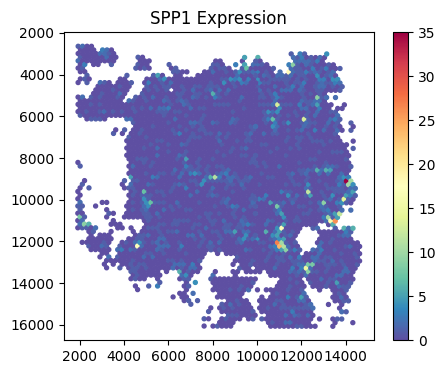

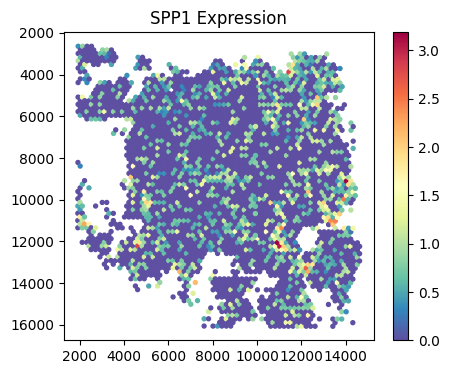

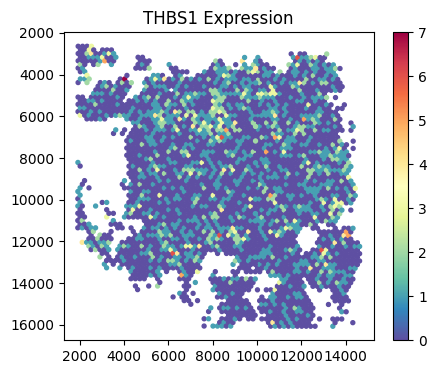

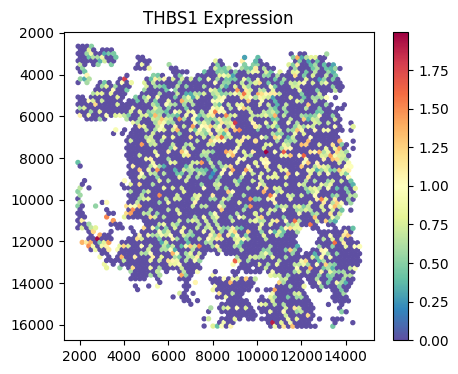

In [13]:
fig_path = 'Figures/'
save_dir = os.path.join(demo_data, fig_path)
os.makedirs(save_dir, exist_ok=True)  

fstplt.gene_expr(adata_count, adata_count.to_df(), gene_selet='SPP1', marker='o', 
                 s=8, figsize=(5, 4), cnt_color='Spectral_r', save_path=f'{demo_data}{fig_path}SPP1_expr_count1.pdf')
fstplt.gene_expr(adata_norml, adata_norml.to_df(), gene_selet='SPP1', marker='o', 
                 s=8, figsize=(5, 4), cnt_color='Spectral_r', save_path=f'{demo_data}{fig_path}SPP1_expr_norml1.pdf')
fstplt.gene_expr(adata_count, adata_count.to_df(), gene_selet='THBS1', marker='o', 
                 s=8, figsize=(5, 4), cnt_color='Spectral_r', save_path=f'{demo_data}{fig_path}THBS1_expr_count1.pdf')
fstplt.gene_expr(adata_norml, adata_norml.to_df(), gene_selet='THBS1', marker='o', 
                 s=8, figsize=(5, 4), cnt_color='Spectral_r', save_path=f'{demo_data}{fig_path}THBS1_expr_norml1.pdf')

## 2. Train model and Internal validation

**Input: three input file**

- `image_embed_path`: image embedding from **Setp0** `Image_feature_extraction.py` \
- `spatial_pos_path`: ordered ST spot coords, in `f'{demo_data}{link_data}position_order.csv` \
- `reduced_mtx_path`: ordered gene expression, in `f'{demo_data}{link_data}matrix_order.npy` 

The `OrderData` can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1b3Ai14lLdsTR07BXLFJu3vFuB3C54WxJ?usp=sharing).

In [14]:
os.chdir(f'{path}FineST/FineST_demo/')  
image_embed_path = f'{demo_data}ImgEmbeddings/pth_112_14/*.pth' 
spatial_pos_path = f'{demo_data}{link_data}position_order.csv'
reduced_mtx_path = f'{demo_data}{link_data}/matrix_order.npy'

2.1 Train and test model on within spot, with plitting: 80% for train and 20% for test

In [15]:
## add params
params['n_input_matrix'] = len(gene_hv)

## init the model
model = fst.FineSTModel(n_input_matrix=params['n_input_matrix'],
                              n_input_image=params['n_input_image'],
                              n_encoder_hidden_matrix=params["n_encoder_hidden_matrix"],
                              n_encoder_hidden_image=params["n_encoder_hidden_image"],
                              n_encoder_latent=params["n_encoder_latent"],
                              n_projection_hidden=params["n_projection_hidden"],
                              n_projection_output=params["n_projection_output"],
                              n_encoder_layers=params["n_encoder_layers"]).to(device) 
## Load the data
train_loader, test_loader = fst.build_loaders(batch_size=params['batch_size'], 
                                              image_embed_path=image_embed_path, 
                                              spatial_pos_path=spatial_pos_path, 
                                              reduced_mtx_path=reduced_mtx_path, 
                                              image_clacss='Virchow2',
                                              dataset_class='Visium64') 
## Set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=params['inital_learning_rate'], 
                            momentum=0.9, weight_decay=5e-4)
## Load loss function
l = fst.ContrastiveLoss(temperature=params['temperature'], 
                        w1=params['w1'], w2=params['w2'], w3=params['w3'], w4=params['w4'])

## train model
(dir_name, 
 train_losses, test_losses, 
 best_epoch, best_loss) = fst.train_model_fst(params, model, train_loader, test_loader, 
                                          optimizer, l, dir_name, logger, dataset_class='Visium64')

CUDA is available. GPU: NVIDIA A100-PCIE-40GB
Finished loading all files
train/test split completed
2683 671
***** Finished building loaders *****


[2025-06-26 09:57:39] INFO - Begin Training ...
[2025-06-26 09:57:39] INFO - epoch [1/50]


Epoch: 1
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 57.51it/s]


--- 59.60508894920349 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 70.53it/s]
[2025-06-26 09:58:42] INFO - Best epoch_loss: [0: 1.6618]
[2025-06-26 09:58:42] INFO - epoch [2/50]


Epoch: 2
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 86.98it/s]


--- 57.37774848937988 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 78.23it/s]
[2025-06-26 09:59:42] INFO - Best epoch_loss: [1: 1.5290]
[2025-06-26 09:59:42] INFO - epoch [3/50]


Epoch: 3
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 79.44it/s]


--- 55.6493284702301 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 63.36it/s]
[2025-06-26 10:00:42] INFO - Best epoch_loss: [2: 1.5013]
[2025-06-26 10:00:42] INFO - epoch [4/50]


Epoch: 4
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 76.18it/s]


--- 59.999812841415405 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 62.03it/s]
[2025-06-26 10:01:45] INFO - Best epoch_loss: [3: 1.4791]
[2025-06-26 10:01:45] INFO - epoch [5/50]


Epoch: 5
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.54it/s]


--- 56.2105667591095 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 75.02it/s]
[2025-06-26 10:02:45] INFO - Best epoch_loss: [4: 1.4709]
[2025-06-26 10:02:45] INFO - epoch [6/50]


Epoch: 6
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.29it/s]


--- 56.49656677246094 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 88.77it/s]
[2025-06-26 10:03:45] INFO - Best epoch_loss: [5: 1.4677]
[2025-06-26 10:03:45] INFO - epoch [7/50]


Epoch: 7
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 58.87it/s]


--- 58.69375729560852 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 72.32it/s]
[2025-06-26 10:04:47] INFO - Best epoch_loss: [6: 1.4552]
[2025-06-26 10:04:47] INFO - epoch [8/50]


Epoch: 8
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 87.76it/s]


--- 60.04963731765747 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 70.22it/s]
[2025-06-26 10:05:50] INFO - epoch [9/50]


Epoch: 9
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 70.90it/s]


--- 56.72629117965698 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 76.68it/s]
[2025-06-26 10:06:50] INFO - Best epoch_loss: [8: 1.4504]
[2025-06-26 10:06:50] INFO - epoch [10/50]


Epoch: 10
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 76.60it/s]


--- 57.08984303474426 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 85.90it/s]
[2025-06-26 10:07:50] INFO - Best epoch_loss: [9: 1.4477]
[2025-06-26 10:07:50] INFO - epoch [11/50]


Epoch: 11
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 92.46it/s]


--- 57.92353892326355 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 85.48it/s]
[2025-06-26 10:08:51] INFO - Best epoch_loss: [10: 1.4458]
[2025-06-26 10:08:51] INFO - epoch [12/50]


Epoch: 12
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 89.34it/s]


--- 57.3084077835083 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 65.14it/s]
[2025-06-26 10:09:52] INFO - epoch [13/50]


Epoch: 13
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 75.91it/s]


--- 54.78923487663269 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 81.71it/s]
[2025-06-26 10:10:50] INFO - Best epoch_loss: [12: 1.4452]
[2025-06-26 10:10:50] INFO - epoch [14/50]


Epoch: 14
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 76.11it/s]


--- 57.12834358215332 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 68.39it/s]
[2025-06-26 10:11:50] INFO - Best epoch_loss: [13: 1.4409]
[2025-06-26 10:11:50] INFO - epoch [15/50]


Epoch: 15
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 94.41it/s]


--- 55.72413372993469 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 81.00it/s]
[2025-06-26 10:12:50] INFO - Best epoch_loss: [14: 1.4375]
[2025-06-26 10:12:50] INFO - epoch [16/50]


Epoch: 16
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 81.21it/s]


--- 54.684256076812744 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 76.28it/s]
[2025-06-26 10:13:48] INFO - epoch [17/50]


Epoch: 17
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 83.89it/s]


--- 58.04963231086731 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 90.01it/s]
[2025-06-26 10:14:49] INFO - epoch [18/50]


Epoch: 18
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 89.42it/s]


--- 58.307342290878296 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 87.63it/s]
[2025-06-26 10:15:50] INFO - Best epoch_loss: [17: 1.4355]
[2025-06-26 10:15:50] INFO - epoch [19/50]


Epoch: 19
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 93.39it/s]


--- 57.21409821510315 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 75.61it/s]
[2025-06-26 10:16:50] INFO - epoch [20/50]


Epoch: 20
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.86it/s]


--- 57.57716488838196 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 66.08it/s]
[2025-06-26 10:17:51] INFO - Best epoch_loss: [19: 1.4333]
[2025-06-26 10:17:51] INFO - epoch [21/50]


Epoch: 21
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 78.19it/s]


--- 54.84317231178284 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 78.65it/s]
[2025-06-26 10:18:49] INFO - Best epoch_loss: [20: 1.4277]
[2025-06-26 10:18:49] INFO - epoch [22/50]


Epoch: 22
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 81.03it/s]


--- 58.282527685165405 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 88.73it/s]
[2025-06-26 10:19:51] INFO - epoch [23/50]


Epoch: 23
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.40it/s]


--- 57.70358943939209 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 86.56it/s]
[2025-06-26 10:20:51] INFO - epoch [24/50]


Epoch: 24
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 89.37it/s]


--- 60.64518928527832 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 73.51it/s]
[2025-06-26 10:21:55] INFO - Best epoch_loss: [23: 1.4276]
[2025-06-26 10:21:55] INFO - epoch [25/50]


Epoch: 25
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 91.82it/s]


--- 55.24820256233215 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 75.80it/s]
[2025-06-26 10:22:54] INFO - Best epoch_loss: [24: 1.4268]
[2025-06-26 10:22:54] INFO - epoch [26/50]


Epoch: 26
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 75.98it/s]


--- 56.49318766593933 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 80.22it/s]
[2025-06-26 10:23:53] INFO - Best epoch_loss: [25: 1.4244]
[2025-06-26 10:23:53] INFO - epoch [27/50]


Epoch: 27
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 91.79it/s]


--- 57.70456266403198 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 78.21it/s]
[2025-06-26 10:24:54] INFO - epoch [28/50]


Epoch: 28
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 83.10it/s]


--- 58.88906455039978 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 64.45it/s]
[2025-06-26 10:25:56] INFO - epoch [29/50]


Epoch: 29
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 87.27it/s]


--- 55.77562642097473 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 63.47it/s]
[2025-06-26 10:26:55] INFO - epoch [30/50]


Epoch: 30
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 73.48it/s]


--- 55.48478055000305 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 89.83it/s]
[2025-06-26 10:27:54] INFO - Best epoch_loss: [29: 1.4240]
[2025-06-26 10:27:54] INFO - epoch [31/50]


Epoch: 31
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 91.93it/s]


--- 57.57191824913025 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 89.77it/s]
[2025-06-26 10:28:54] INFO - Best epoch_loss: [30: 1.4164]
[2025-06-26 10:28:54] INFO - epoch [32/50]


Epoch: 32
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 92.14it/s]


--- 58.37819457054138 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 84.41it/s]
[2025-06-26 10:29:55] INFO - epoch [33/50]


Epoch: 33
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 91.35it/s]


--- 57.97327947616577 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 70.79it/s]
[2025-06-26 10:30:56] INFO - epoch [34/50]


Epoch: 34
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 87.70it/s]


--- 58.956878900527954 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 70.15it/s]
[2025-06-26 10:31:59] INFO - epoch [35/50]


Epoch: 35
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 80.96it/s]


--- 55.445885181427 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 76.11it/s]
[2025-06-26 10:32:57] INFO - epoch [36/50]


Epoch: 36
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 75.75it/s]


--- 56.98092603683472 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 88.86it/s]
[2025-06-26 10:33:57] INFO - epoch [37/50]


Epoch: 37
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 90.71it/s]


--- 57.8429057598114 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 91.08it/s]
[2025-06-26 10:34:58] INFO - Best epoch_loss: [36: 1.4140]
[2025-06-26 10:34:58] INFO - epoch [38/50]


Epoch: 38
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 93.65it/s]


--- 57.82858228683472 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 78.23it/s]
[2025-06-26 10:35:59] INFO - epoch [39/50]


Epoch: 39
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 77.88it/s]


--- 56.35965585708618 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 70.05it/s]
[2025-06-26 10:36:59] INFO - Best epoch_loss: [38: 1.4126]
[2025-06-26 10:36:59] INFO - epoch [40/50]


Epoch: 40
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 73.59it/s]


--- 57.01607322692871 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 89.68it/s]
[2025-06-26 10:37:59] INFO - epoch [41/50]


Epoch: 41
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.28it/s]


--- 58.155341148376465 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 90.04it/s]
[2025-06-26 10:39:00] INFO - epoch [42/50]


Epoch: 42
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 83.23it/s]


--- 58.08670520782471 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 66.39it/s]
[2025-06-26 10:40:01] INFO - Best epoch_loss: [41: 1.4113]
[2025-06-26 10:40:01] INFO - epoch [43/50]


Epoch: 43
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 82.06it/s]


--- 55.607423067092896 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 76.59it/s]
[2025-06-26 10:41:00] INFO - Best epoch_loss: [42: 1.4111]
[2025-06-26 10:41:00] INFO - epoch [44/50]


Epoch: 44
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 70.15it/s]


--- 56.20764207839966 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 91.17it/s]
[2025-06-26 10:41:59] INFO - Best epoch_loss: [43: 1.4094]
[2025-06-26 10:41:59] INFO - epoch [45/50]


Epoch: 45
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.52it/s]


--- 58.11171913146973 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 67.95it/s]
[2025-06-26 10:43:00] INFO - epoch [46/50]


Epoch: 46
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 84.72it/s]


--- 58.1940016746521 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 73.78it/s]
[2025-06-26 10:44:02] INFO - Best epoch_loss: [45: 1.4080]
[2025-06-26 10:44:02] INFO - epoch [47/50]


Epoch: 47
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.13it/s]


--- 57.98853588104248 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 90.79it/s]
[2025-06-26 10:45:03] INFO - epoch [48/50]


Epoch: 48
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 84.94it/s]


--- 57.45691657066345 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 75.82it/s]
[2025-06-26 10:46:03] INFO - epoch [49/50]


Epoch: 49
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 73.67it/s]


--- 55.2108838558197 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 84.30it/s]
[2025-06-26 10:47:02] INFO - epoch [50/50]


Epoch: 50
train model


100%|██████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 75.94it/s]


--- 56.996336698532104 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 87.16it/s]
[2025-06-26 10:48:02] INFO - Done!, Best epoch_loss: [45: 1.4080]
[2025-06-26 10:48:02] INFO - Finished Training


Done!, Best epoch_loss: [45: 1.4080]
Training epoch time: 3022.9008 seconds


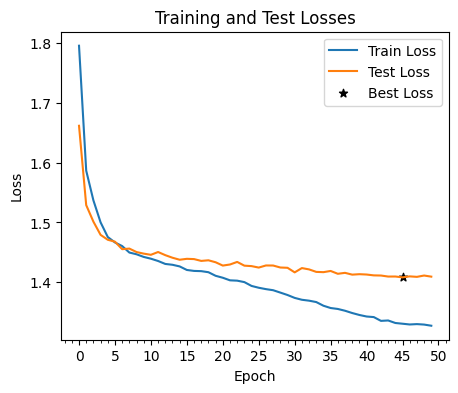

In [16]:
fst.loss_curve(train_losses, test_losses, best_epoch, best_loss, max_step=5, min_step=1, 
               fig_size=(5, 4), format='svg', save_path=f'{demo_data}{fig_path}HCC_loss_curve.svg')

<div class="alert alert-info">

**Note**
The above cell for `section 2.1` needs to be run more than once by setting different parameters in the given `.json` file, if the correlation in `section 3.4` is not satisfying. If one obtains a good performance, one can save the `dir_name` and then directly use it to load the trained model and infer gene expression, and doesn't need to run `section 2.1` again. Recommended parameter fine-tuning and its range: `training_epoch`: 40~60; 
`temperature`: 0.01-0.05.

</div>

## 3. Inference, Imputation and Evaluation on "within spot"

3.1 Infer the gene expression of within spots

You can use the `dir_name` obtained from section 2.1, here we use our trained `logging/20250622170940952737` at [Goole Drive](https://drive.google.com/drive/folders/1Z6MqL3uouhlgmhV5Ouz_d58Di-ExK5Bt?usp=sharing) for paper results repeated.

In [17]:
!pwd

/mnt/lingyu/nfs_share2/Python/FineST/FineST_demo


In [18]:
# dir_name ='logging/20250623110308213551'
dir_name = 'logging/20250625000152293514'

In [19]:
## Load the trained model
model = fst.load_model(dir_name, parameter_file_path, gene_hv)

## Load test data
test_loader = fst.build_loaders_inference(batch_size=adata.shape[0], 
                                          image_embed_path=image_embed_path, 
                                          spatial_pos_path=spatial_pos_path, 
                                          reduced_mtx_path=reduced_mtx_path,
                                          image_clacss='Virchow2',
                                          dataset_class='Visium64')
## Inference
(matrix_profile,
 reconstructed_matrix, 
 recon_ref_adata_image_f2, 
 reconstructed_matrix_reshaped, 
 input_coord_all) = fst.infer_model_fst(model, test_loader, logger, dataset_class='Visium64')

CUDA is available. GPU: NVIDIA A100-PCIE-40GB


[2025-06-26 10:48:11] INFO - Running inference task...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


***** batch_size=adata.shape[0] doen't effect *****
torch.Size([3354, 1073])
torch.Size([3354, 64, 1280])
1
1
1
***** *****
Finished extractting test data


[2025-06-26 10:48:13] INFO - Running inference task DONE!


Inference within spots: 2.1570 seconds
Reconstructed_matrix_reshaped shape:  torch.Size([214656, 1073])


3.2 Get coordinates of sub-spots from within spots

We use `reshape_latent_image()` function to convert the super-resolved gene expression with 16X or 64X relolution `reconstructed_matrix_reshaped` (torch.Size([21296, 596]) or torch.Size([85184, 596])) into tensor format `reconstructed_matrix_reshaped_tensor` (torch.Size([1331, 16, 596]) or torch.Size([1331, 64, 596])).

In [20]:
## Get the sub-spot level gene expression of all genes on all within-spots
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium64')
(_, _, all_spot_all_variable,
 C2, adata_infer) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                adata, gene_hv, patch_size=112, dataset_class='Visium64')
print(adata_infer)

_, adata_infer_reshape = fst.reshape_latent_image(torch.tensor(adata_infer.X), dataset_class='Visium64')
adata_infer_spot = fst.reshape2adata(adata, adata_infer_reshape, gene_hv)
print(adata_infer_spot)

## save adata
adata_infer.write_h5ad(f'{demo_data}{save_data}adata_infer.h5ad')    # adata 85184 × 596
adata_infer_spot.write_h5ad(f'{demo_data}{save_data}adata_infer_spot.h5ad')    # adata 1331 × 596

pixel_step (half of patch_size): 7.0
AnnData object with n_obs × n_vars = 214656 × 1073
    obs: 'x', 'y'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3354 × 1073
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
Here, `adata_infer` is the inferred super-resolved gene expression data with 16X or 64X solution.
</div>

pixel_step (half of patch_size): 7.0
first_spot_first_variable shape: (64,)


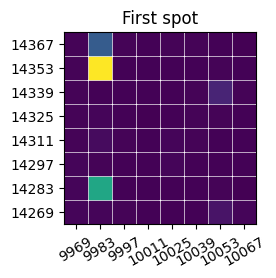

In [21]:
## Plot the first_spot_first_variable spiltting
(first_spot_first_variable, C,
 _, _, _) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor, adata, gene_hv, 
                                         p=0, q=0, patch_size=112, dataset_class='Visium64')
print("first_spot_first_variable shape:", first_spot_first_variable.shape)

fstplt.subspot_expr(C, first_spot_first_variable, patch_size=112, dataset_class='Visium64', 
                     marker='s', s=250, rotation=30, fig_size=(2.5, 2.5), format='svg', 
                    save_path=f'{demo_data}{fig_path}spot_splitting.svg')

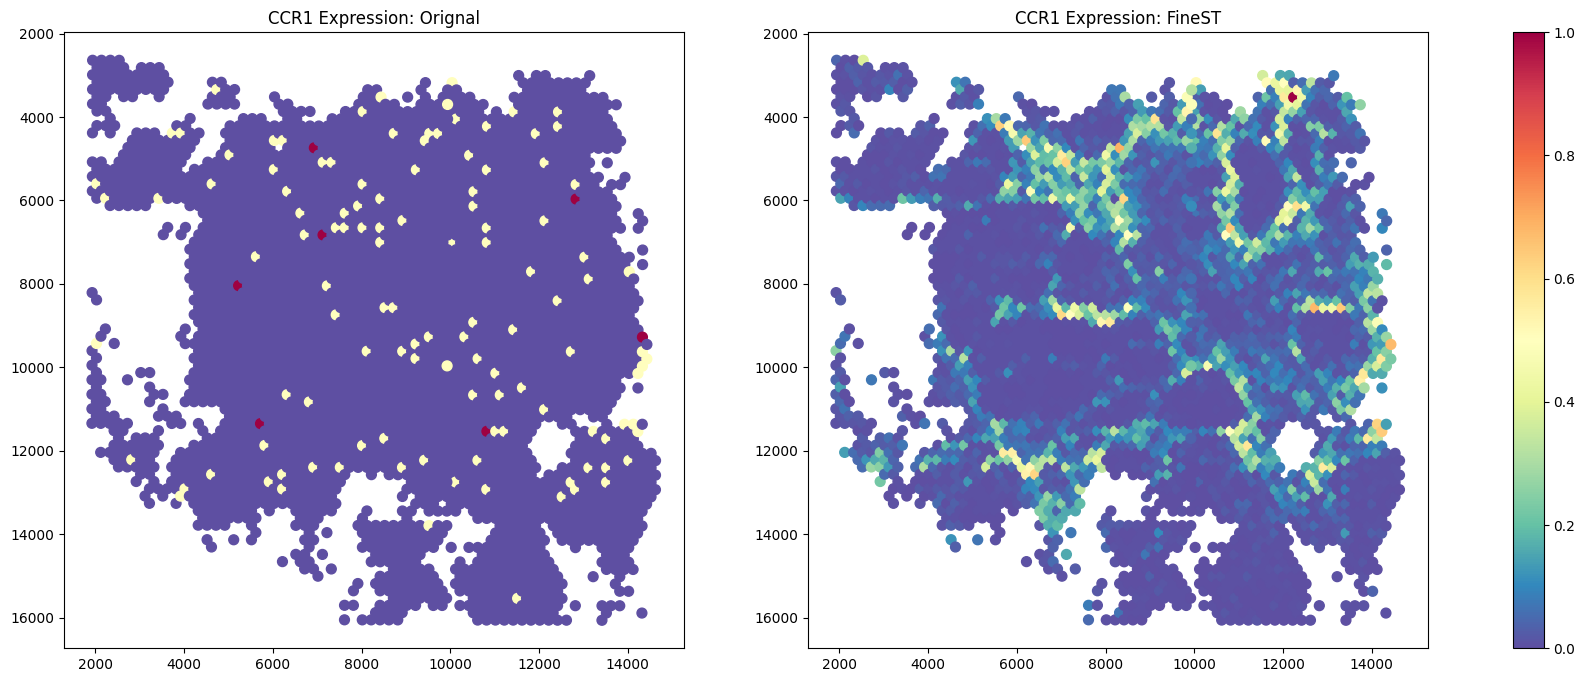

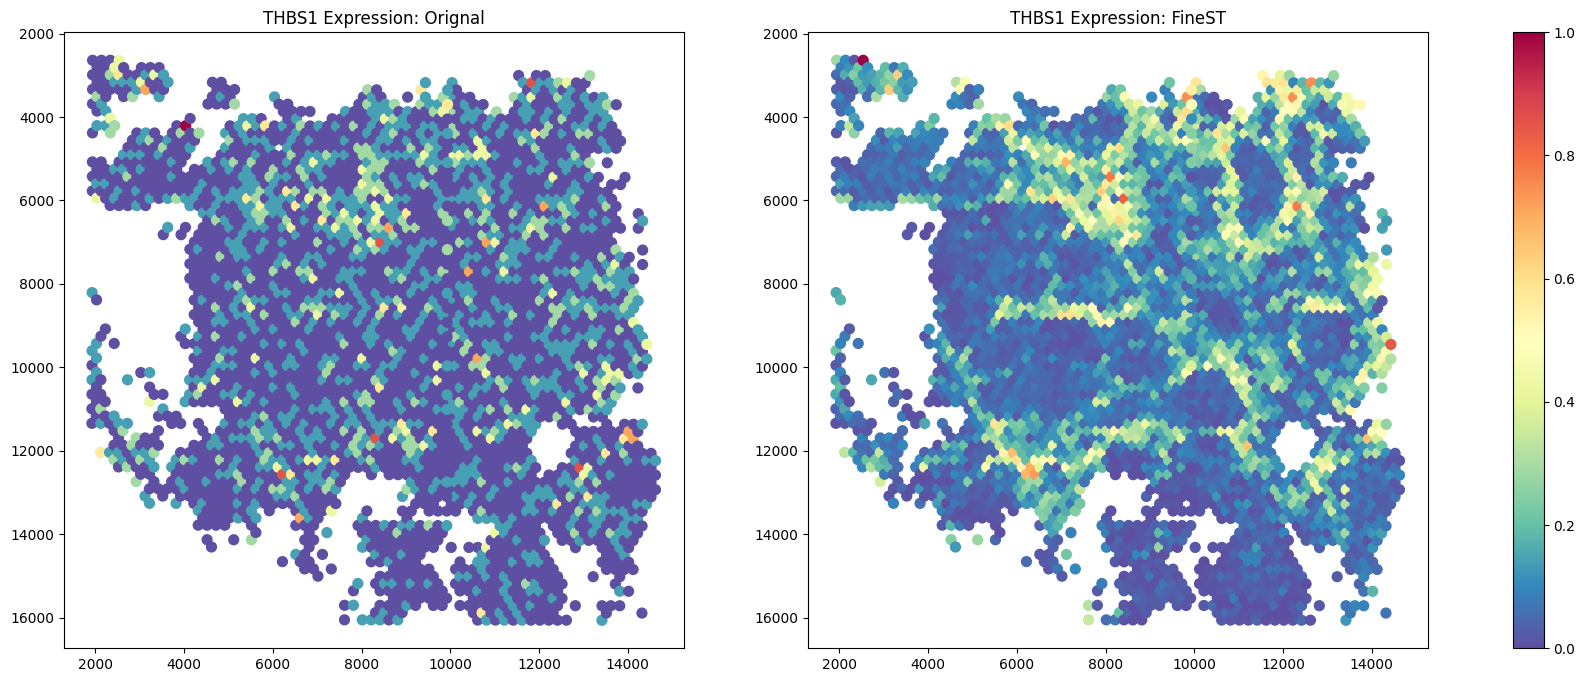

In [22]:
fstplt.gene_expr_compare(adata, "CCR1", adata_infer_reshape, gene_hv, s=50, cmap='Spectral_r', save_path=None)
fstplt.gene_expr_compare(adata, "THBS1", adata_infer_reshape, gene_hv, s=50, cmap='Spectral_r', save_path=None)

In [23]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from scipy.stats import pearsonr
# from sklearn.linear_model import LinearRegression

# def plot_regression_with_stats(
#     x, y, 
#     weight=None, 
#     moran_func=None,
#     x_label='X', 
#     y_label='Y', 
#     title='Regression Plot',
#     figsize=(5, 5), 
#     dpi=150,
#     scatter_alpha=0.5, 
#     line_color='red',
#     trans=False, format='pdf', save_path=None
# ):
#     """
#     Plot regression with Pearson R, p-value, (optional) Moran R and regression equation.
#     All annotations are in English.
#     """
#     x = np.array(x).flatten()
#     y = np.array(y).flatten()

#     ## Pearson correlation
#     r, p = pearsonr(x, y)

#     ## Linear regression
#     X_ = x.reshape(-1, 1)
#     model = LinearRegression().fit(X_, y)
#     slope = model.coef_[0]
#     intercept = model.intercept_

#     # ## Moran R if function and weight are provided
#     # moran_str = ''
#     # if (moran_func is not None) and (weight is not None):
#     #     try:
#     #         moran_r = moran_func(x, y, weight)[0].item()
#     #         moran_str = f'Moran R = {moran_r:.2f}\n'
#     #     except Exception as e:
#     #         moran_str = ''
#     #         print(f"Warning: Moran R calculation failed: {e}")

#     ## Plotting
#     fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
#     sns.regplot(
#         x=x, y=y, ax=ax, 
#         scatter_kws={'alpha': scatter_alpha}, 
#         line_kws={'color': line_color}
#     )

#     ## Compose annotation string
#     annotation = (
#         # f"{moran_str}"
#         f"Pearson R = {r:.2f}\n"
#         f"p-value = {p:.2e}\n"
#         f"Regression: y = {slope:.2f}x + {intercept:.2f}"
#     )

#     ax.text(
#         0.95, 0.00, annotation, color='black', 
#         ha='right', va='bottom', transform=ax.transAxes
#     )

#     ax.set_title(title)
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)

#     plt.tight_layout()

#     if save_path is not None:
#         plt.savefig(save_path, transparent=trans, format=format,
#                     dpi=300, bbox_inches='tight')
        
#     plt.show()

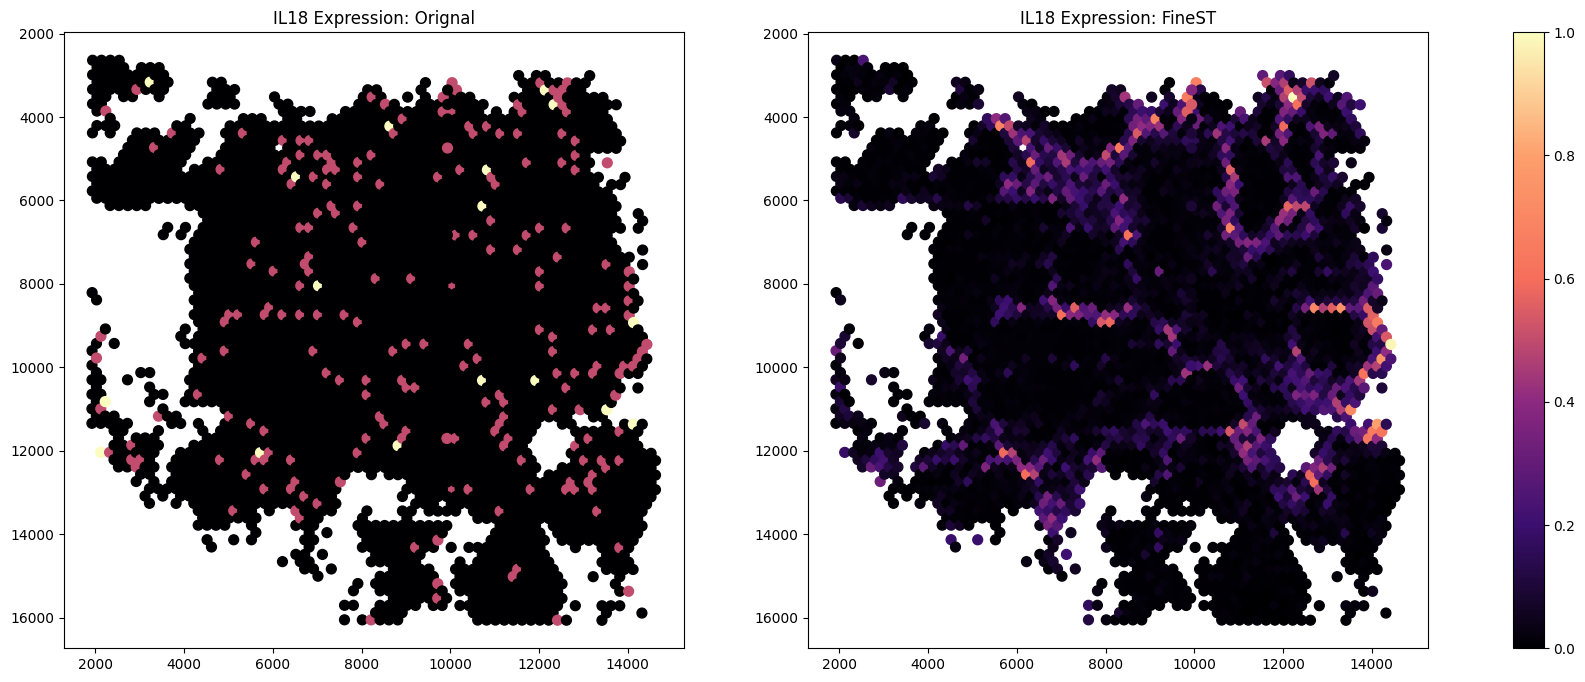

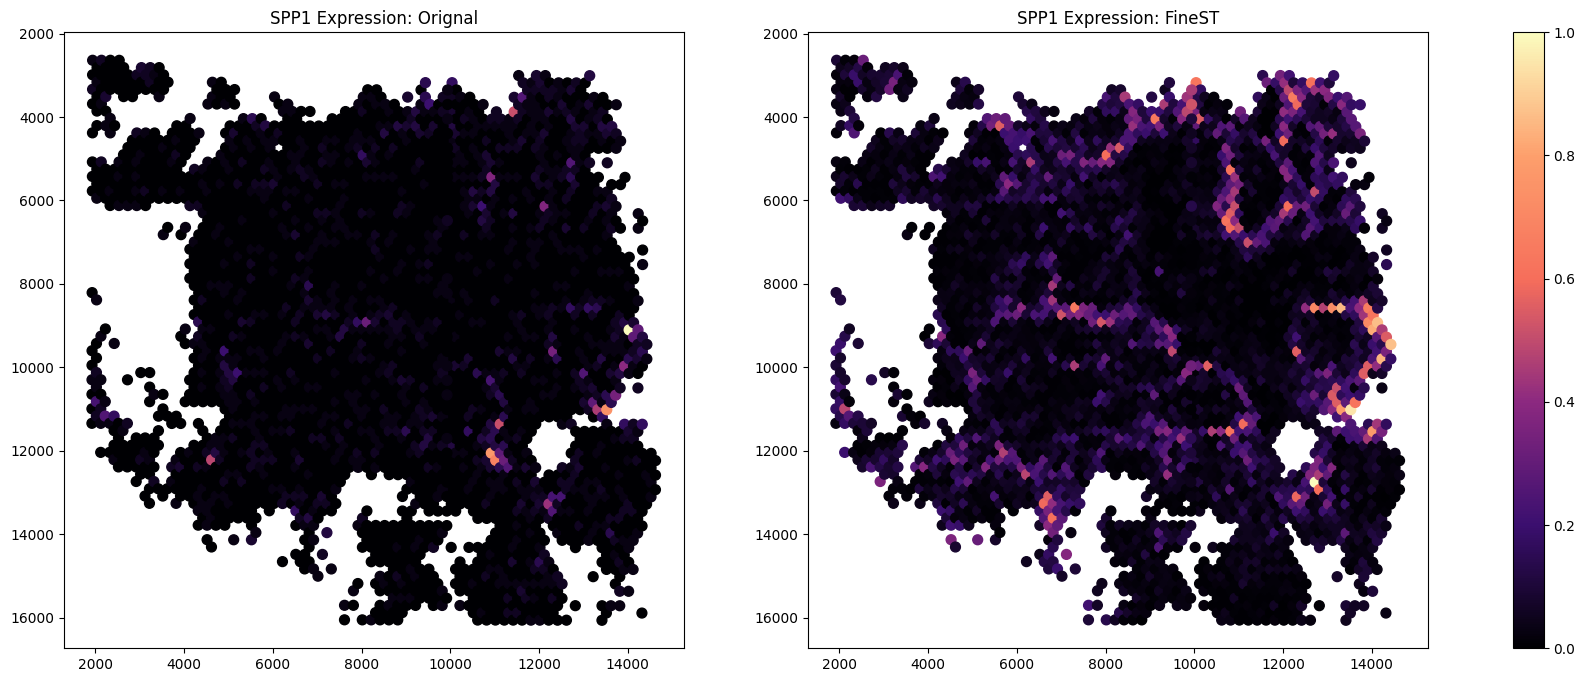

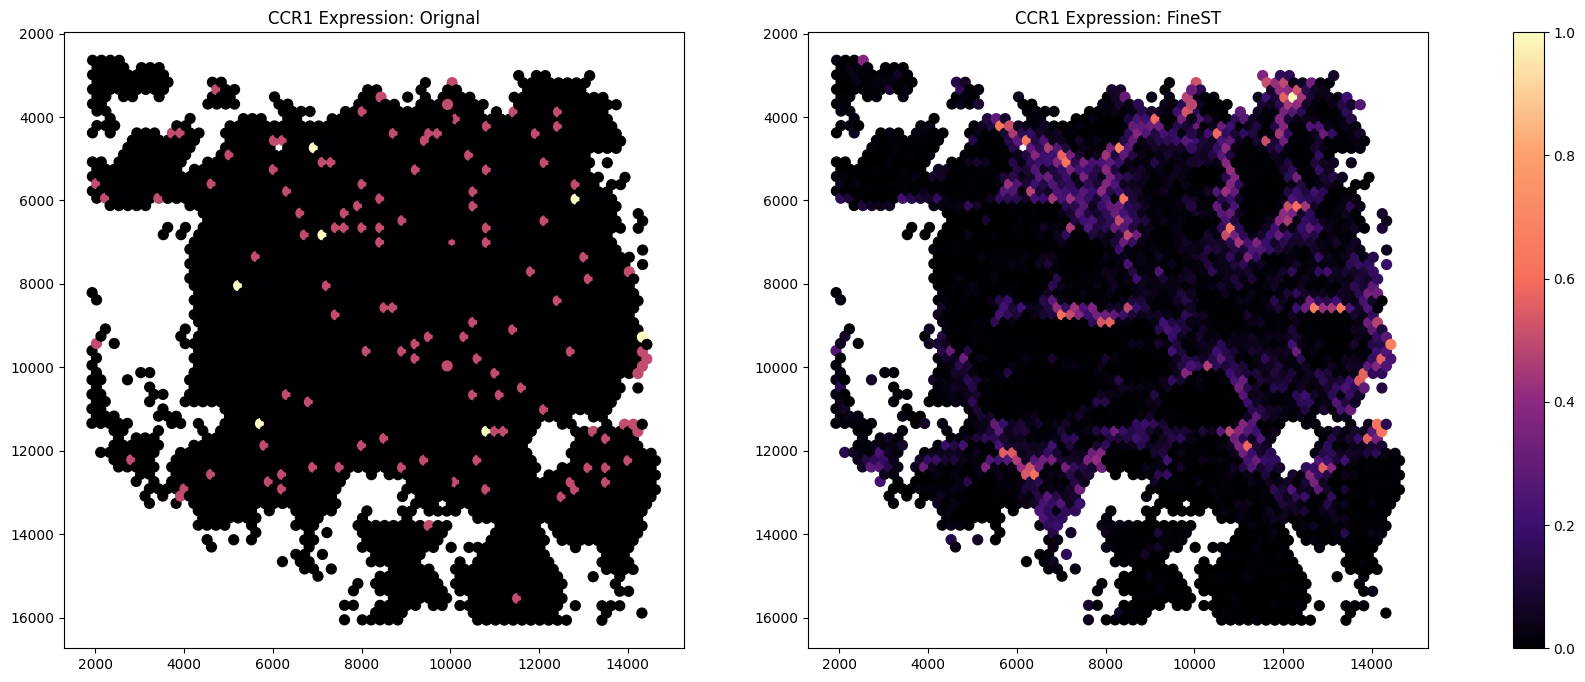

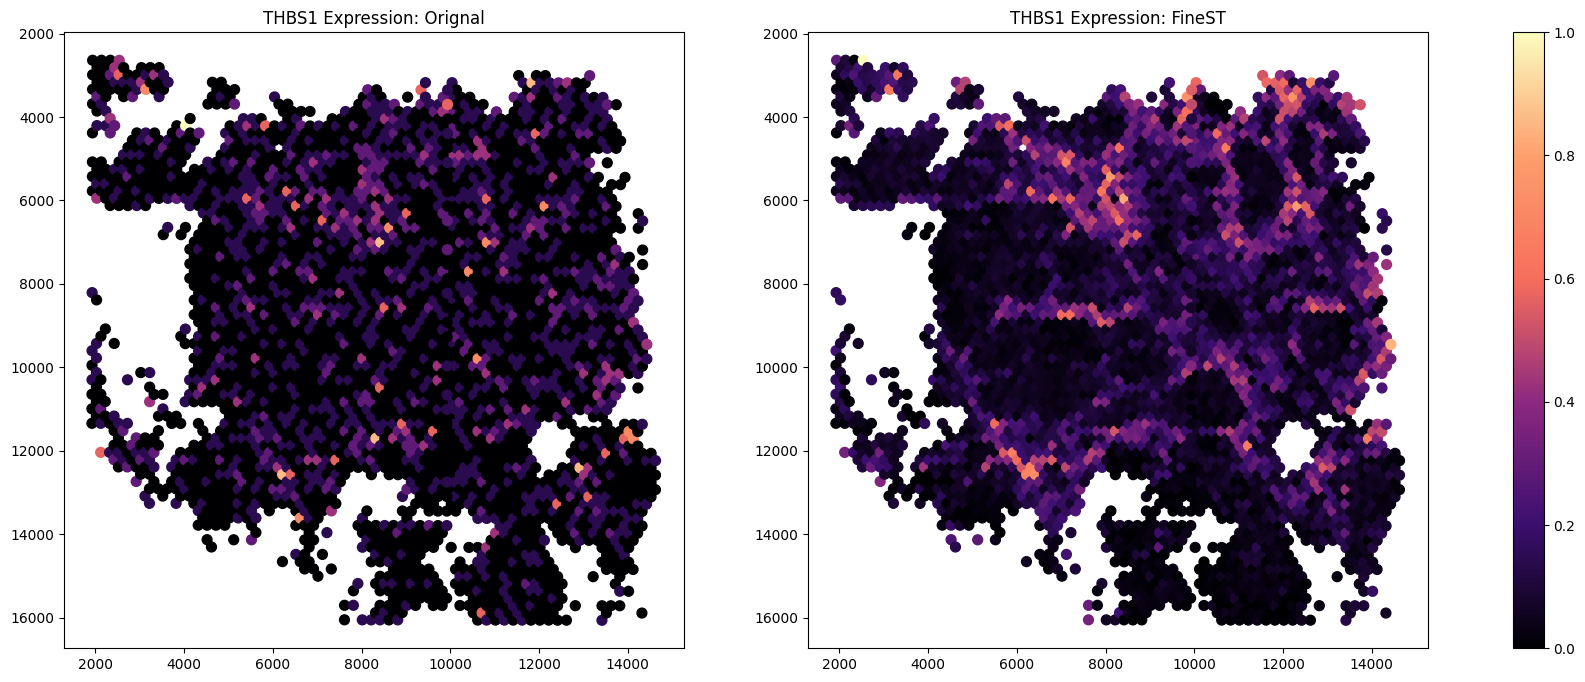

In [24]:
## Show marker gene expression -- only infer from image
fstplt.gene_expr_compare(adata, "IL18", adata_infer_reshape, gene_hv, s=50, save_path=None)
fstplt.gene_expr_compare(adata, "SPP1", adata_infer_reshape, gene_hv, s=50, save_path=None)
fstplt.gene_expr_compare(adata, "CCR1", adata_infer_reshape, gene_hv, s=50, save_path=None)
fstplt.gene_expr_compare(adata, "THBS1", adata_infer_reshape, gene_hv, s=50, save_path=None)

# fstplt.gene_expr(adata, adata_infer_reshape, gene_selet='SPP1', marker='o', 
#                  s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}SPP1_expr_infer_spot_within.pdf')
# fstplt.gene_expr(adata, adata_infer_reshape, gene_selet='IL18', marker='o', 
#                  s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}IL18_expr_infer_spot_within.pdf')

[2025-06-26 10:48:31] INFO - mean correlation of spots: 0.2813895983876798


mean correlation of spots:  0.2813895983876798


[2025-06-26 10:48:31] INFO - mean correlation of genes: 0.1552038035528444


mean correlation of genes:  0.1552038035528444


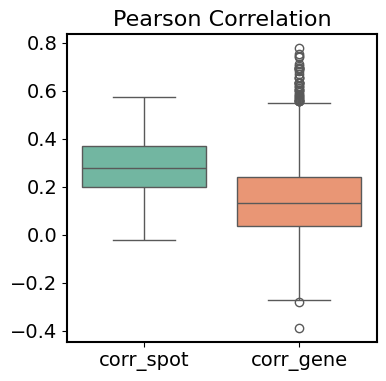

[2025-06-26 10:48:32] INFO - mean correlation of spots: 0.30050578344731066


mean correlation of spots:  0.30050578344731066


[2025-06-26 10:48:32] INFO - mean correlation of genes: 0.08241296190103015


mean correlation of genes:  0.08241296190103015


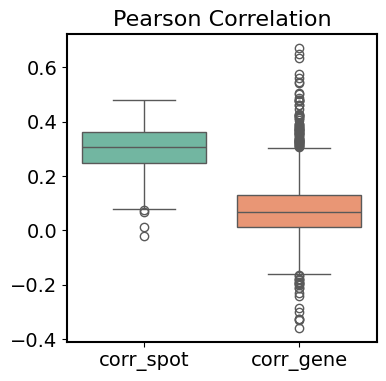

In [25]:
## save the correlation -- -- only infer from image
fstplt.mean_cor_box(adata, adata_infer_reshape, logger, save_path=f'{demo_data}{fig_path}Boxplot_infer_cor_count.pdf')
fstplt.mean_cor_box(adata_norml, adata_infer_reshape, logger, save_path=f'{demo_data}{fig_path}Boxplot_infer_cor_norml.pdf')

Pearson correlations:  0.1552038035528444


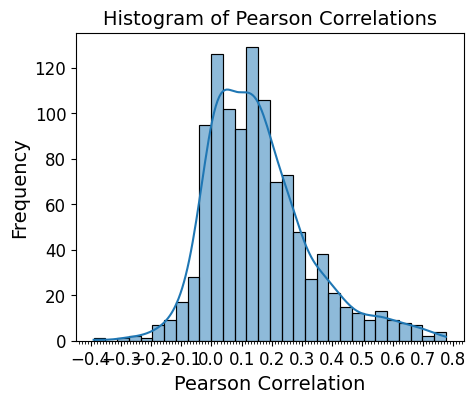

In [26]:
## Pearson correlations
fstplt.cor_hist(adata, adata_infer_spot.to_df(), 
                 fig_size=(5, 4), trans=False, format='svg', 
                 save_path=f'{demo_data}{fig_path}Hist_infer_cor_count.svg')

3.3 Impute the gene expression of sub-spots

Input: two input files: \
    - `adata`: original spot-level gene expression data (within spots). \
    - `adata_infer`: inferred super-resolved gene expression data (within spots). 

Input: three input files: \
    - `adata_impt`: `= w*adata_infer + (1-w)*sudo_adata`, predicted super-resolved gene expression data (here `w=0.5`).\
    - `sudo_adata`: Imputed data using the nearest `k` neighbors of within spots (here `k=6`). \
    - ` data_impt`: predicted super-resolved gene expression data in tensor form (within spots).

In [27]:
# adata_smooth = fst.impute_adata(adata, adata_infer, C2, gene_hv, 
#                                 dataset_class='Visium64', weight_exponent=2)
adata_smooth = fst.impute_adata(adata_norml, adata_infer, C2, gene_hv, 
                                dataset_class='Visium64', weight_exponent=2)

Smoothing time: 61.1371 seconds


In [28]:
adata_imput, data_impt = fst.weight_adata(adata_infer, adata_smooth, gene_hv, w=0.98)
print(adata_imput)

_, data_impt_reshape = fst.reshape_latent_image(data_impt, dataset_class='Visium64')
adata_imput_spot = fst.reshape2adata(adata, data_impt_reshape, gene_hv)
print(adata_imput_spot)

## save adata
adata_imput.write_h5ad(f'{demo_data}{save_data}_adata_imput.h5ad')    # adata: 85184 × 596
adata_imput_spot.write_h5ad(f'{demo_data}{save_data}adata_imput_spot.h5ad')    # adata: 1331 × 596

AnnData object with n_obs × n_vars = 214656 × 1073
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3354 × 1073
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


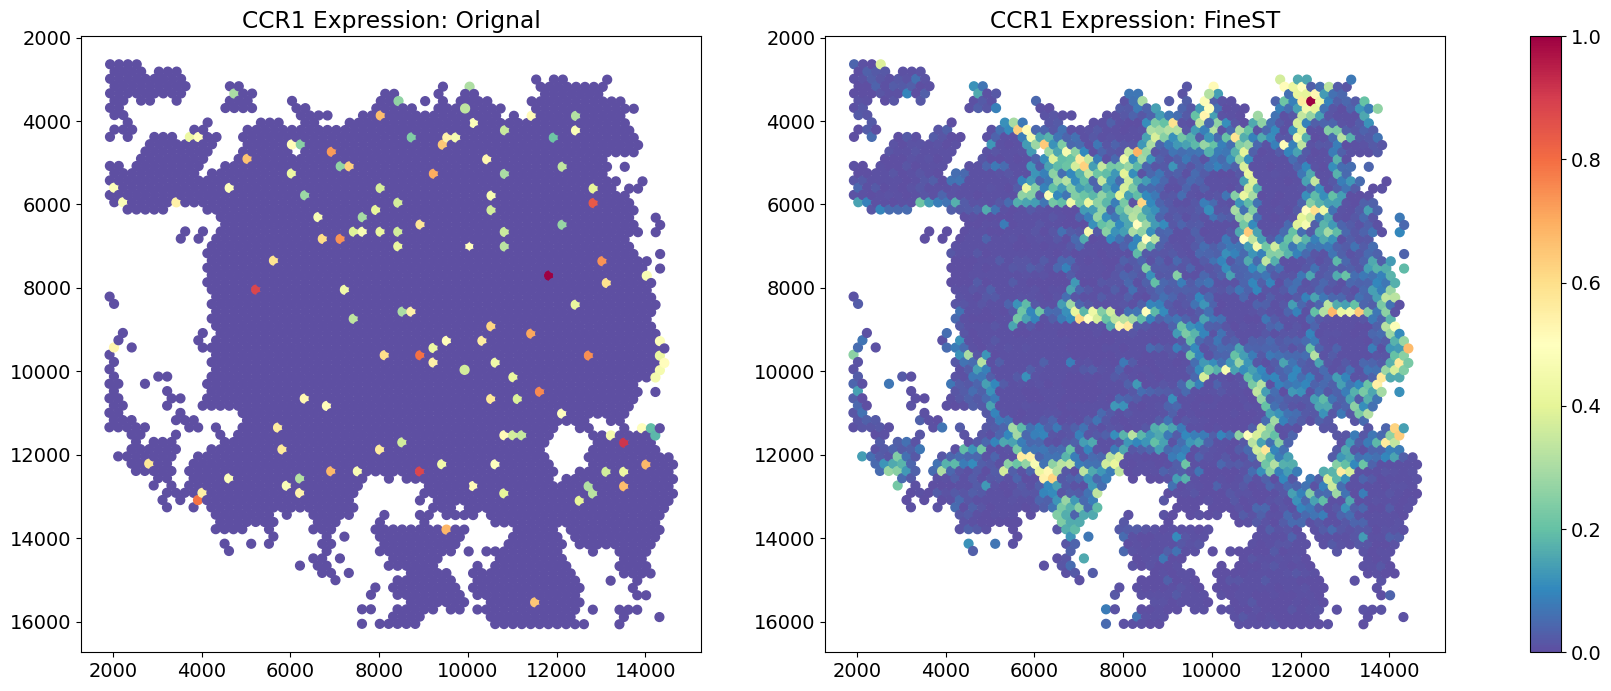

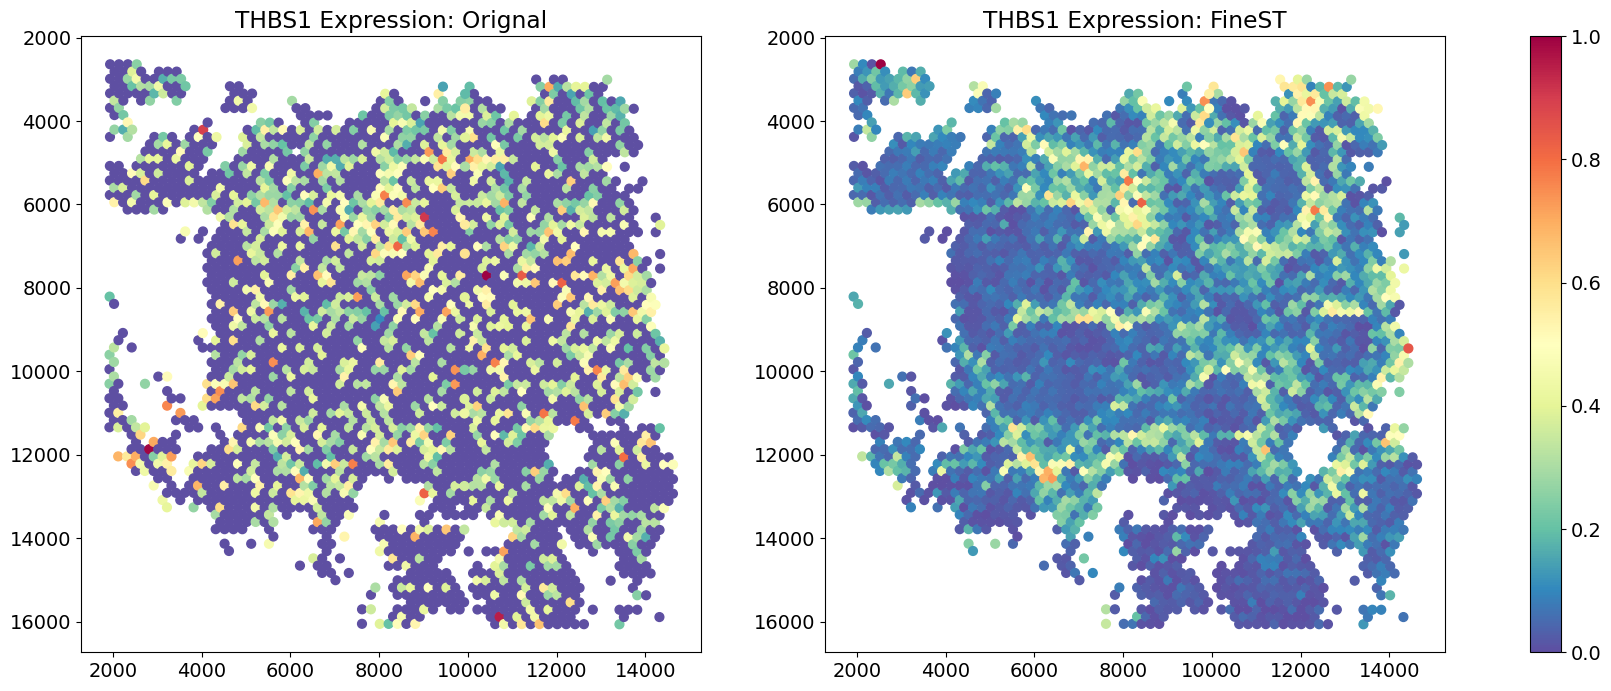

In [40]:
fstplt.gene_expr_compare(adata_norml, "CCR1", adata_infer_reshape, gene_hv, s=40, cmap='Spectral_r', 
                         # save_path=f'{demo_data}{fig_path}CCR1_expr_infer_spot_within1.pdf')
                         save_path=None)
fstplt.gene_expr_compare(adata_norml, "THBS1", adata_infer_reshape, gene_hv, s=40, cmap='Spectral_r', 
                         # save_path=f'{demo_data}{fig_path}THBS1_expr_infer_spot_within1.pdf')
                         save_path=None)

In [30]:
# plot_regression_with_stats(
#     adata_norml.to_df()['CCR1'], 
#     adata_norml.to_df()['THBS1'], 
#     # weight=adata.obsp['weight'],
#     # moran_func=sdm.utils.Moran_R,
#     x_label='CCR1',
#     y_label='THBS1',
#     title='CCR1 VS THBS1',
#     save_path=f'{demo_data}{fig_path}CCR1_VS_THBS1_Original.pdf'
# )

# plot_regression_with_stats(
#     adata_imput_spot.to_df()['CCR1'], 
#     adata_imput_spot.to_df()['THBS1'], 
#     # weight=adata.obsp['weight'],
#     # moran_func=sdm.utils.Moran_R,
#     x_label='CCR1',
#     y_label='THBS1',
#     title='CCR1 VS THBS1',
#     save_path=f'{demo_data}{fig_path}CCR1_VS_THBS1_FineST.pdf'
# )

<div class="alert alert-info">

**Note**
For performance evaluation, we integrate super-resolved gene expression `data_impt` into spot-level gene expression `data_impt_reshape` (i.e., from 16x sub-spot level to spot level)
</div>

3.4 Visualization: selected gene (Original vs. FineST)

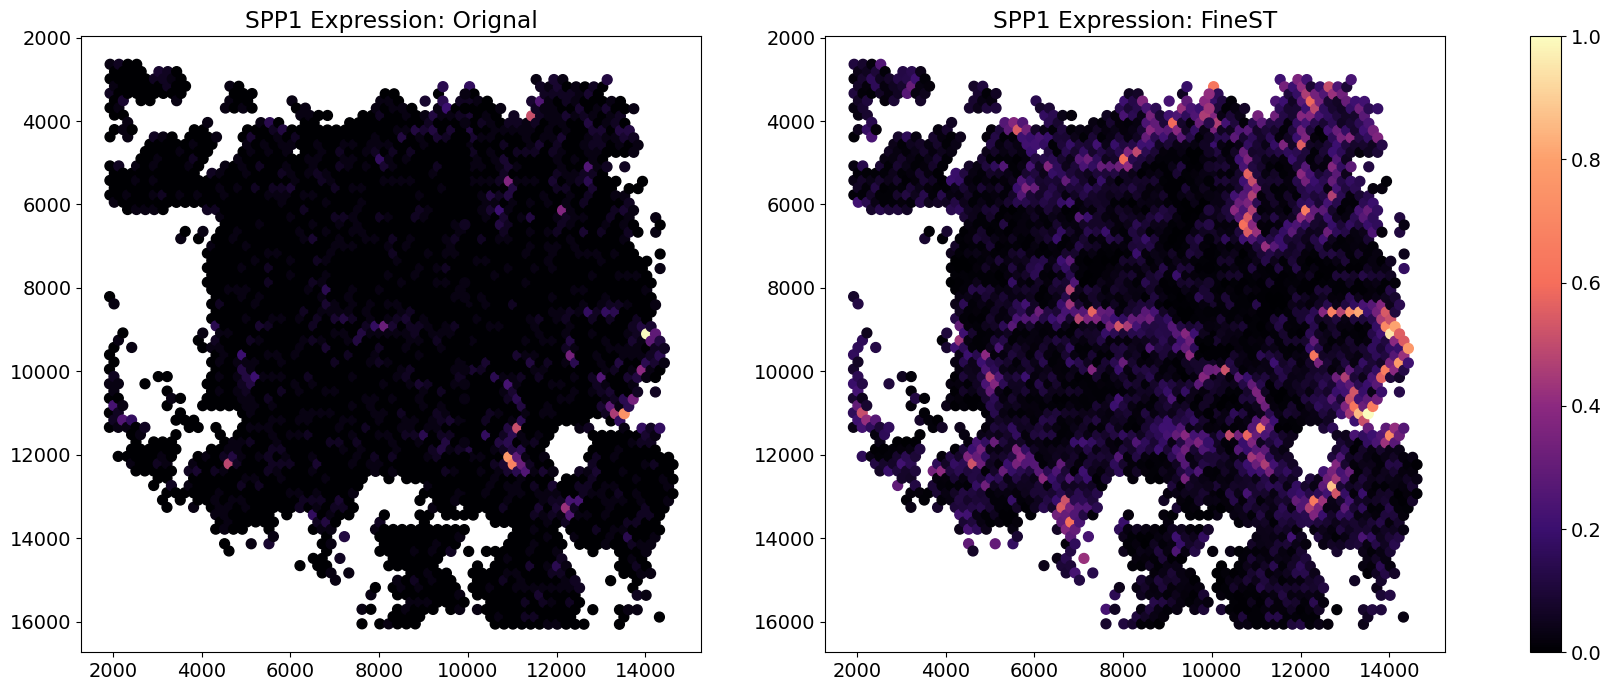

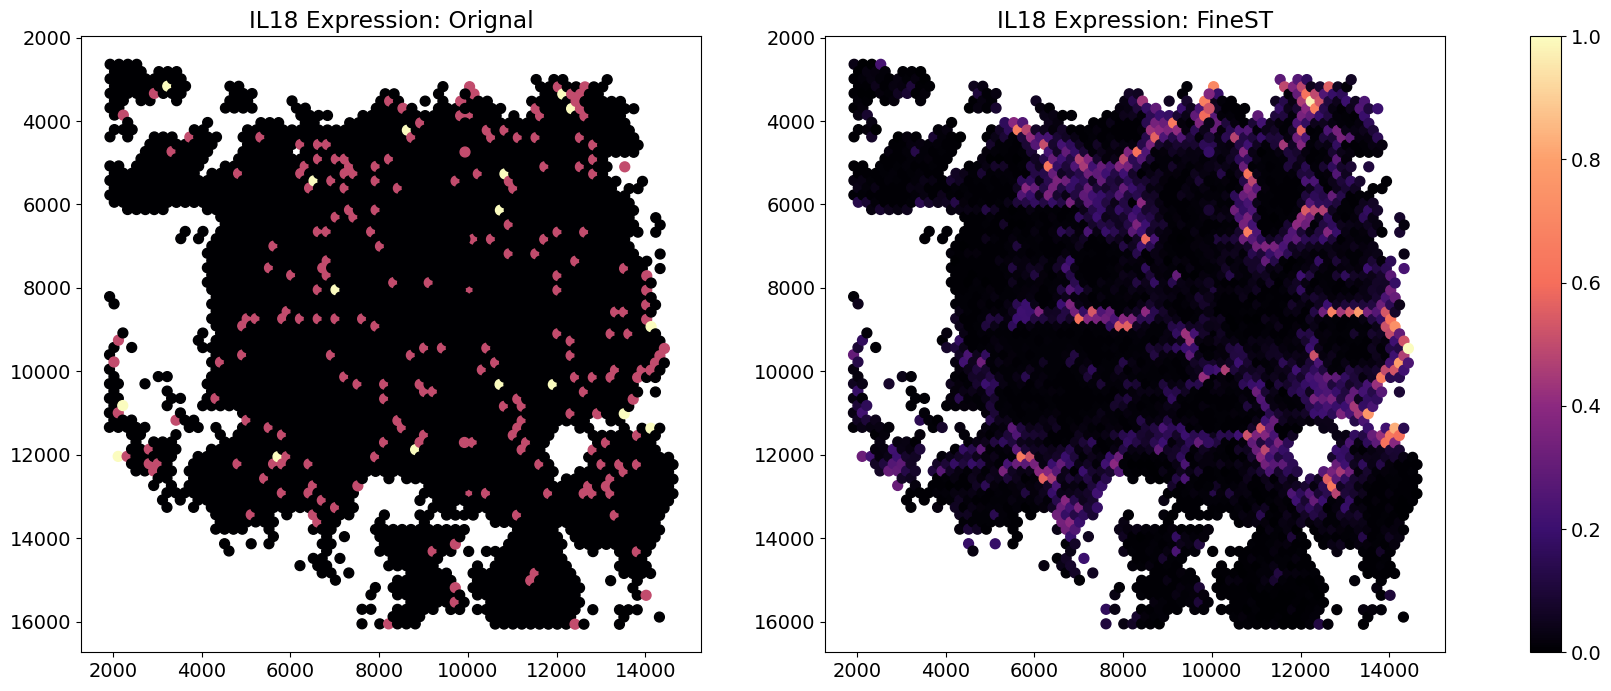

In [31]:
fstplt.gene_expr_compare(adata, "SPP1", data_impt_reshape, gene_hv, s=50, save_path=None)
fstplt.gene_expr_compare(adata, "IL18", data_impt_reshape, gene_hv, s=50, save_path=None)

# fstplt.gene_expr(adata, data_impt_reshape, gene_selet='SPP1', marker='o', 
#                  s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}SPP1_expr_imput_spot_within.pdf')
# fstplt.gene_expr(adata, data_impt_reshape, gene_selet='IL18', marker='o', 
#                  s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}IL18_expr_imput_spot_within.pdf')

3.4 Correlation: Selected gene、all spots and all genes、mean correlation box

The correlation can be used as a measure to evaluate the gene expression prediction performance. Here we provide three functions: \
    - `sele_gene_cor`: show the selected gene correlation (Reconstructed by FineST vs. Original). \
    - `mean_cor`     : calculate the mean correlation of all spots or all genes. \
    - `mean_cor_box` : box plot of correlation for all spots or all genes.

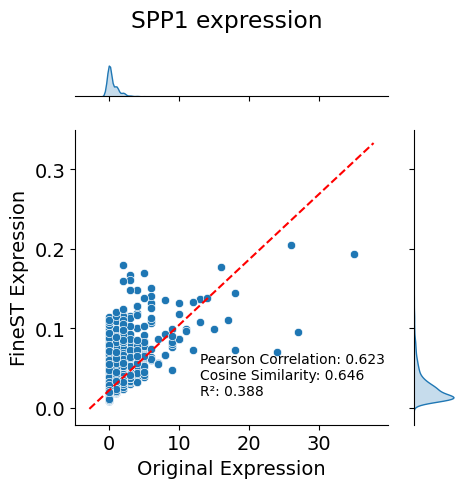

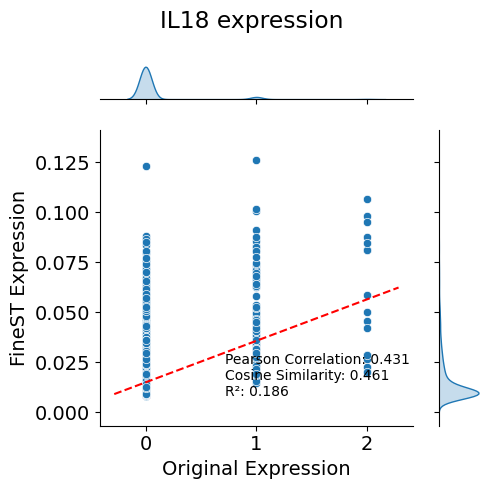

In [32]:
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "SPP1", 
                     ylabel='FineST Expression', title = "SPP1 expression", size=5, 
                     save_path=f'{demo_data}{fig_path}SPP1_cor_imput_spot_within.pdf') 
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "IL18", 
                     ylabel='FineST Expression', title = "IL18 expression", size=5, 
                     save_path=f'{demo_data}{fig_path}IL18_cor_imput_spot_within.pdf') 

In [33]:
logger.info("Running Gene Correlation task...")
(pearson_cor_gene, 
 spearman_cor_gene, 
 cosine_sim_gene) = fst.mean_cor(adata, data_impt_reshape, 'reconf2', sample="gene")
logger.info("Running Gene Correlation task DINE!")

[2025-06-26 00:11:35] INFO - Running Gene Correlation task...


matrix1:  (3354, 1073)
matrix2:  (3354, 1073)
Mean Pearson correlation coefficient--reconf2: 0.5337


[2025-06-26 00:11:36] INFO - Running Gene Correlation task DINE!


Mean Spearman correlation coefficient--reconf2: 0.4272
Mean cosine similarity--reconf2: 0.4798


[2025-06-26 09:19:04] INFO - mean correlation of spots: 0.32540014023037167


mean correlation of spots:  0.32540014023037167


[2025-06-26 09:19:04] INFO - mean correlation of genes: 0.5337301774275744


mean correlation of genes:  0.5337301774275744


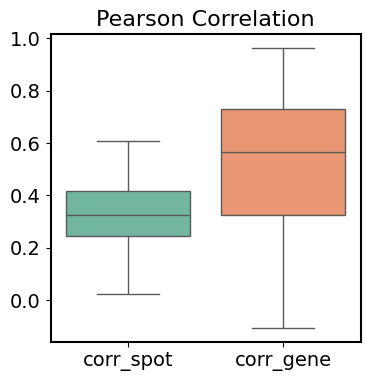

In [36]:
fstplt.mean_cor_box(adata, data_impt_reshape, logger, save_path=f'{demo_data}{fig_path}Boxplot_imput_cor_count.pdf')

<div class="alert alert-info">

**Note**
Here the `adata_impt` is the imputed spot-level gene expression from FineST, it only contains the given 1331 within spots. The comparisons are based on the original adata `patient1_adata_orignal.h5ad` vs. FineST's predicted adata `patient1_adata.h5ad`.

</div>

## 4. Infer gene expression of "within spot" and "between spot" 

**Spot_interpolate**
```Python
cd ~/FineST_demo
conda activate FineST
python ./demo/Spot_interpolation.py 
    --position_path HCC_data/spatial/tissue_positions_list.csv 
```

**Step0: HE image feature extraction**
```Python
python ./demo/Image_feature_extraction.py \
   --dataset NEW_HCC \
   --position_path HCC_data/spatial/tissue_positions_list_add.csv  \
   --rawimage_path HCC_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method Virchow2 \
   --patch_size 112 \
   --output_img HCC_data/ImgEmbeddings/NEW_pth_112_14_image \
   --output_pth HCC_data/ImgEmbeddings/NEW_pth_112_14 \
   --logging HCC_data/ImgEmbeddings/
```

4.1 Get all spot coordinates (within spot & between spot) of image embeddings

Input: two input file pathways: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `Image_feature_extraction.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `Image_feature_extraction.py`. 

In [25]:
## Add coords for each .pth file
file_paths_spot = os.listdir(f'{demo_data}ImgEmbeddings/pth_112_14/')
file_paths_between_spot = os.listdir(f'{demo_data}ImgEmbeddings/NEW_pth_112_14/')
file_paths_all = file_paths_spot + file_paths_between_spot
print("file_paths_spot number: ", len(file_paths_spot))
print("file_paths_between_spot number:", len(file_paths_between_spot))
print("file_paths_all number:", len(file_paths_all))

## Merge, sort and process file paths
data_all = fst.get_image_coord_all(file_paths_all)
position_order_allspot = pd.DataFrame(data_all, columns=['pixel_y', 'pixel_x'])

## save all spots
position_order_allspot.to_csv(f'{demo_data}{link_data}position_order_all.csv', index=False, header=False)

file_paths_spot number:  1331
file_paths_between_spot number: 3708
file_paths_all number: 5039


<div class="alert alert-info">

**Note**
The above two cells for `section 4.1` only need to be run once, aiming to generate the ordered ST spot coordinates `position_order_all.csv` according to image pixel coordinates.

</div>

4.2 Load all spot image embeddings with their coordinates

In [26]:
import glob
file_paths_spot = f'{demo_data}ImgEmbeddings/pth_112_14/*.pth'
file_paths_between_spot = f'{demo_data}ImgEmbeddings/NEW_pth_112_14/*.pth'
spatial_pos_path=f'{demo_data}{link_data}position_order_all.csv'

4.4 Load the trained model to infer all spots

In [27]:
dir_name ='logging/20250622170940952737'

In [28]:
## Load the trained model
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)

## load all spot (within and between) spots data
all_dataset = fst.build_loaders_inference_allimage(batch_size=len(file_paths_all), 
                                                   file_paths_spot=file_paths_spot, 
                                                   file_paths_between_spot=file_paths_between_spot, 
                                                   spatial_pos_path=spatial_pos_path, 
                                                   dataset_class='Visium64')
## inference
logger.info("Running inference tesk between spot...")
start_time = time.time()
(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset, dataset_class='Visium64')
print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2:", recon_ref_adata_image_f2.shape)
logger.info("Running inference tesk between spot DONE!")

***** Building loaders_inference between spot *****


[2025-06-21 22:22:40] INFO - Running inference tesk between spot...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.44it/s]
[2025-06-21 22:22:41] INFO - Running inference tesk between spot DONE!


***** batch_size=adata.shape[0] *****
torch.Size([5039, 64, 1280])
1
Finished extractting image_between_spot data
--- 0.19009113311767578 seconds ---
recon_ref_adata_image_f2: (5039, 596)


4.5 Visualization all spots

In [29]:
## process_and_check_duplicates of the coordinates of all spots (within and between)
spatial_loc_all = fst.get_allspot_coors(input_coord_all)
print(spatial_loc_all)

Are there any duplicate rows? : False
[[10014.5  9836. ]
 [10015.5  9462.5]
 [10020.5  7596.5]
 ...
 [ 9924.   3117. ]
 [ 9925.   2743. ]
 [ 9927.   1997. ]]


CD70 gene expression dim: (5039, 1)
CD70 gene expression: 
 [[0.01452262]
 [0.01196492]
 [0.01567534]
 ...
 [0.02649067]
 [0.04429931]
 [0.01894626]]


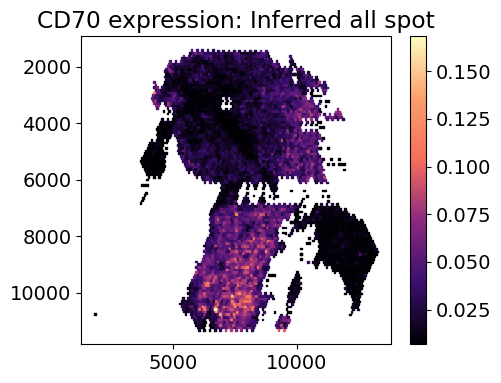

CD27 gene expression dim: (5039, 1)
CD27 gene expression: 
 [[0.15109763]
 [0.20213561]
 [0.16679761]
 ...
 [0.05947825]
 [0.05123311]
 [0.05395708]]


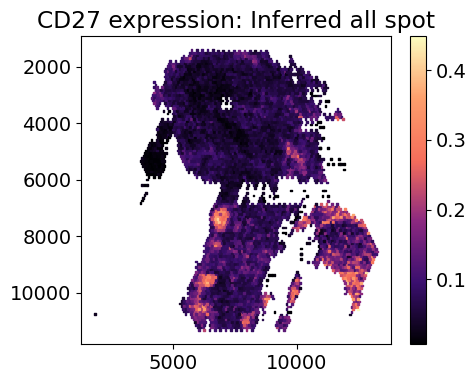

In [30]:
fstplt.gene_expr_allspots("SPP1", spatial_loc_all, recon_ref_adata_image_f2, 
                          gene_hv, 'Inferred all spot', s=1.5, marker='s',
                          figsize=(5, 4), save_path=f'{demo_data}{fig_path}SPP1_expr_infer_allspot.pdf')
fstplt.gene_expr_allspots("IL18", spatial_loc_all, recon_ref_adata_image_f2, 
                          gene_hv, 'Inferred all spot', s=1.5, marker='s',
                          figsize=(5, 4), save_path=f'{demo_data}{fig_path}IL18_expr_infer_allspot.pdf')

4.6 Visualization all sub-spots

In [31]:
## Get the sub-spot level gene expression of all genes in all spots
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium64')
print("reconstructed_matrix_reshaped_tensor size: ", reconstructed_matrix_reshaped_tensor.shape)

(_, _, all_spot_all_variable, 
 C2, adata_infer_all) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_all, gene_hv, patch_size=112, dataset_class="Visium64")
print(adata_infer_all)

reconstructed_matrix_reshaped_tensor size:  torch.Size([5039, 64, 596])
pixel_step (half of patch_size): 7.0
AnnData object with n_obs × n_vars = 322496 × 596
    obs: 'x', 'y'
    obsm: 'spatial'


In [32]:
# fstplt.gene_expr_allspots("SPP1", C2, all_spot_all_variable, gene_hv, 
#                            'Inferred all spot', marker='s', s=0.3, 
#                           figsize=(15, 12), save_path=f'{demo_data}{fig_path}SPP1_expr_infer_allsubspot.pdf')
# fstplt.gene_expr_allspots("IL18", C2, all_spot_all_variable, gene_hv, 
#                            'Inferred all spot', marker='s', s=0.3, 
#                           figsize=(15, 12), save_path=f'{demo_data}{fig_path}IL18_expr_infer_allsubspot.pdf')

## 5. Imputate sub-spot gene expression using measured spot expression

5.1 Impute the gene expression of all sub-spots from all spots (within spots and between spots)

In [33]:
adata_smooth_all = fst.impute_adata(adata, adata_infer_all, C2, gene_hv, dataset_class='Visium64', weight_exponent=2)
print(adata_smooth_all)
adata_impt_all, data_impt_all = fst.weight_adata(adata_infer_all, adata_smooth_all, gene_hv, w=0.5)  
print(adata_impt_all)

## save adata 
adata_impt_all.write_h5ad(f'{demo_data}{save_data}adata_imput_all_subspot.h5ad')    # aadata: 322496 × 596

Smoothing time: 80.9326 seconds
AnnData object with n_obs × n_vars = 322496 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 322496 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
Here, `adata_impt_all` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all.h5ad` contains about 1331x4x16 sub-spots. (1331 within spots, 1331x3 between spots, 16x resolution).

</div>

5.2 Convert super-resolved gene expression to spot-level and save the imputated spot-level adata

In [34]:
_, adata_impt_all_reshape = fst.reshape_latent_image(data_impt_all, dataset_class='Visium64')
adata_impt_spot = fst.reshape2adata(adata, adata_impt_all_reshape, gene_hv, spatial_loc_all)

## save adata
adata_impt_spot.write_h5ad(f'{demo_data}{save_data}adata_imput_all_spot.h5ad')    # adata: 5039 × 596

<div class="alert alert-info">

**Note**
Here, `adata_impt_spot` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all_spot.h5ad` contains about 1331x4 spots. (1331 within spots, 1331x3 between spots), it is integrated from `patient1_adata_all.h5ad` using the `reshape_latent_image` function.

</div>

5.3 Visualization: gene at all spot

CD70 gene expression dim: (5039, 1)
CD70 gene expression: 
 [[0.00726131]
 [0.00598246]
 [0.00783767]
 ...
 [0.03040026]
 [0.05672635]
 [0.02774626]]


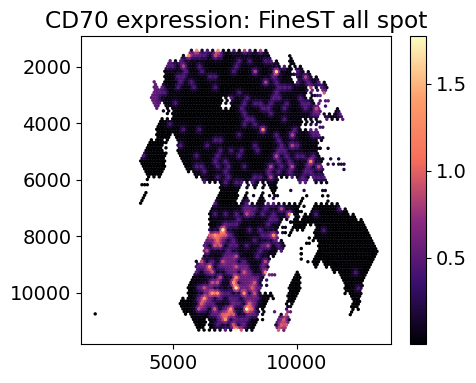

CD27 gene expression dim: (5039, 1)
CD27 gene expression: 
 [[0.88855172]
 [0.89158093]
 [1.3451065 ]
 ...
 [0.90905065]
 [0.07715213]
 [0.0387373 ]]


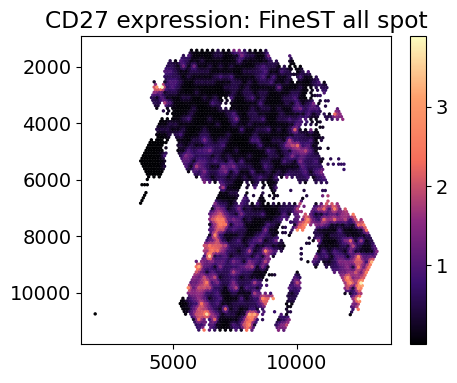

In [35]:
fstplt.gene_expr_allspots("SPP1", spatial_loc_all, adata_impt_all_reshape, gene_hv, 
                          'FineST all spot', marker='h', s=2.5, 
                           figsize=(5, 4), save_path=f'{demo_data}{fig_path}SPP1_expr_imput_allspot.pdf')
fstplt.gene_expr_allspots("IL18", spatial_loc_all, adata_impt_all_reshape, gene_hv, 
                          'FineST all spot', marker='h', s=2.5, 
                           figsize=(5, 4), save_path=f'{demo_data}{fig_path}IL18_expr_imput_allspot.pdf')

5.4 Visualization: gene at all sub-spot

In [36]:
# fstplt.gene_expr_allspots("SPP1", C2, adata_impt_all.X, gene_hv, 
#                           'FineST all sub-spot', marker='s', s=0.3, figsize=(15, 12), 
#                           save_path=f'{demo_data}{fig_path}SPP1_expr_imput_allsubspot.pdf')
# fstplt.gene_expr_allspots("IL18", C2, adata_impt_all.X, gene_hv, 
#                           'FineST all sub-spot', marker='s', s=0.3, figsize=(15, 12), 
#                           save_path=f'{demo_data}{fig_path}IL18_expr_imput_allsubspot.pdf')

## 6. Infer and impute gene expression at "single-cell" level

<div class="alert alert-info">

**Note**
Section 6 directly infers super-resolved gene expression based on image features from ``nuclei segmentation``. The image embeddings `sc_pth_14_14` is based on `adata_imput_all_spot.adata` from **Nuclei segmentation** . The results `NucleiSegments` can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1YE2JILfbbj1HTPZDmVGxy07gr6R_7mTP?usp=drive_link).
</div>

**Nuclei segmentation**
```Python
python ./demo/StarDist_nuclei_segmente.py \
    --tissue HCC_allspot_p075 \
    --out_dir HCC_data/NucleiSegments \
    --adata_path HCC_data/SaveData/adata_imput_all_spot.h5ad \
    --img_path HCC_data/20210809-C-AH4199551.tif \
    --prob_thresh 0.75
```

**Step0: HE image feature extraction**
```Python
python ./demo/Image_feature_extraction.py \
   --dataset sc_HCC \
   --position_path HCC_data/NucleiSegments/HCC_allspot_p075/position_all_tissue_sc.csv  \
   --rawimage_path HCC_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method Virchow2 \
   --patch_size 14 \
   --output_img HCC_data/ImgEmbeddings/sc_pth_14_14_image \
   --output_pth HCC_data/ImgEmbeddings/sc_pth_14_14 \
   --logging HCC_data/ImgEmbeddings/
```

6.1 Infer the gene expression of at single-cell resolution

You can use the `dir_name` just obtained from Section 2 (Model training), but just like Section 3, here we use our trained `logging/20250622170940952737` for paper results repeated.

In [37]:
dir_name ='logging/20250622170940952737'  

In [38]:
file_paths_sc = sorted(os.listdir(f'{demo_data}/ImgEmbeddings/sc_pth_14_14/'))
print("Image embedding file: ", file_paths_sc[:2])

## Image patch position
data_all_sc = fst.get_image_coord_all(file_paths_sc)
spatial_loc_sc = pd.DataFrame(data_all_sc, columns=['pixel_y', 'pixel_x'])

## save .csv file
spatial_loc_sc.to_csv(f'{demo_data}{link_data}/position_order_sc.csv', index=False, header=False)

Image embedding file:  ['sc_NPC_10000.0_9328.81908402034.pth', 'sc_NPC_10000.0_9579.185992854487.pth']


<div class="alert alert-info">

**Note**
The above two cells for `section 6.1` only need to be run once, aiming to generate the ordered ST spot coordinates `position_order_sc.csv` according to image pixel coordinates.

</div>

In [39]:
import glob
image_embed_path_sc = f'{demo_data}/ImgEmbeddings/sc_pth_14_14/*.pth'
spatial_pos_path_sc = f'{demo_data}{link_data}/position_order_sc.csv'

In [40]:
## load models
model = fst.load_model(dir_name, parameter_file_path, params, gene_hv)   
model.to(device)

## load all data
all_dataset_sc = fst.build_loaders_inference_allimage(batch_size=len(file_paths_sc),
                                                       file_paths_spot=image_embed_path_sc, 
                                                       spatial_pos_path=spatial_pos_path_sc, 
                                                       dataset_class='VisiumSC')

## inference
logger.info("Running inference tesk single-nuclei...")
start_time = time.time()
(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset_sc, dataset_class='VisiumSC')
print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2 shape:", recon_ref_adata_image_f2.shape)
logger.info("Running inference tesk single-nuclei DONE!")

***** Building loaders_inference sc image *****


[2025-06-21 22:29:07] INFO - Running inference tesk single-nuclei...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]
[2025-06-21 22:29:08] INFO - Running inference tesk single-nuclei DONE!


***** batch_size=adata.shape[0] *****
torch.Size([40068, 1, 1280])
1
Finished extractting image_between_spot data
--- 1.1706655025482178 seconds ---
recon_ref_adata_image_f2 shape: (40068, 596)


In [41]:
spatial_loc_sc = fst.get_allspot_coors(input_coord_all)
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='VisiumSC')
(_, _, all_spot_all_variable, 
 C2, adata_infer_sc) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_sc, gene_hv, patch_size=14, dataset_class="VisiumSC")
adata_smooth_sc = fst.impute_adata(adata, adata_infer_sc, C2, gene_hv, dataset_class='VisiumSC', weight_exponent=2)
adata_impt_sc, data_impt_sc = fst.weight_adata(adata_infer_sc, adata_smooth_sc, gene_hv, w=0.5)
print(adata_impt_sc)

## save adata
adata_impt_sc.write_h5ad(f'{demo_data}{save_data}adata_imput_all_sc.h5ad')    # adata: 40068 × 596

Are there any duplicate rows? : False
pixel_step (half of patch_size): 7.0
Smoothing time: 10.4625 seconds
AnnData object with n_obs × n_vars = 40068 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


In [42]:
## Save inferred expression
# fstplt.gene_expr_allspots("SPP1", spatial_loc_sc, recon_ref_adata_image_f2, gene_hv, 
#                           'Inferred single-cell', s=0.6, 
#                          figsize=(5, 4), save_path=f'{demo_data}{fig_path}SPP1_expr_infer_allsc.pdf')
# fstplt.gene_expr_allspots("IL18", spatial_loc_sc, recon_ref_adata_image_f2, gene_hv, 
#                           'Inferred single-cell', s=0.6, 
#                           figsize=(5, 4), save_path=f'{demo_data}{fig_path}IL18_expr_infer_allsc.pdf')

CD70 gene expression dim: (40068, 1)
CD70 gene expression: 
 [[0.1575841 ]
 [0.05276948]
 [0.08433484]
 ...
 [0.3343965 ]
 [0.06877968]
 [0.08192167]]


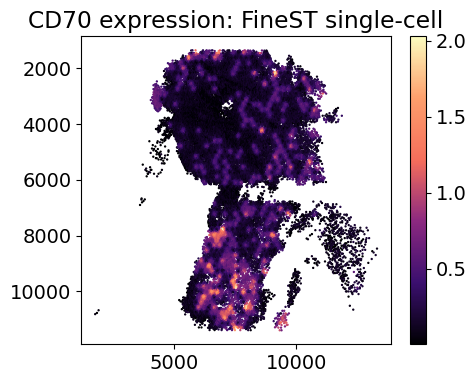

CD27 gene expression dim: (40068, 1)
CD27 gene expression: 
 [[0.39988833]
 [1.77117822]
 [1.08396507]
 ...
 [1.61580575]
 [0.78978671]
 [0.86478635]]


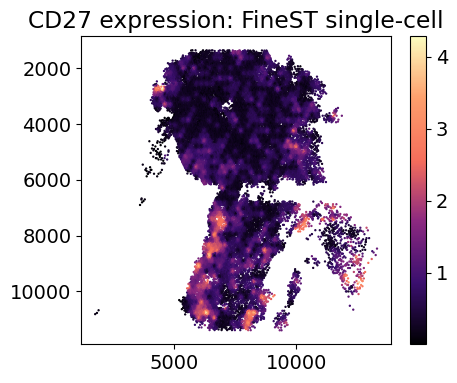

In [43]:
## Save imputed expression
_, adata_impt_sc_reshape = fst.reshape_latent_image(data_impt_sc, dataset_class='VisiumSC')

fstplt.gene_expr_allspots("SPP1", spatial_loc_sc, adata_impt_sc_reshape, gene_hv, 
                          'FineST single-cell', s=0.6, 
                         figsize=(5, 4), save_path=f'{demo_data}{fig_path}SPP1_expr_imput_allsc.pdf')
fstplt.gene_expr_allspots("IL18", spatial_loc_sc, adata_impt_sc_reshape, gene_hv, 
                          'FineST single-cell', s=0.6, 
                         figsize=(5, 4), save_path=f'{demo_data}{fig_path}IL18_expr_imput_allsc.pdf')

<div class="alert alert-info">

**Note**
The above all .h5ad files `SaveData` can be downloaded from [Goole Drive](https://drive.google.com/drive/folders/1Ub6z8EBCfAIPIZ2VYCWzyu9tdt9m1XHY?usp=sharing).
</div>